## Yash Patel
### DS2500 Final Project - Green Line Reliability 
### Part 2: Machine Learning + Visualizations
#### ____________________________________________________________________________________________________________________

### Machine Learning Models:
#### 1. Linear Regression Model
##### Time-Series Forecasting
#### 2. Random Forest
##### Feature analysis and non-linear relationships
#### ____________________________________________________________________________________________________________________

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

FILEPATH = "/Users/ytpatel3/Downloads/green_line_data/"
FILENAMES = [FILEPATH + "January_green_line_data.csv", FILEPATH + "February_green_line_data.csv", FILEPATH + "March_green_line_data.csv",
             FILEPATH + "April_green_line_data.csv", FILEPATH + "May_green_line_data.csv", FILEPATH + "June_green_line_data.csv",
             FILEPATH + "July_green_line_data.csv", FILEPATH + "August_green_line_data.csv", FILEPATH + "September_green_line_data.csv"]

#### Read CSVs into one master dataframe 

In [2]:
data_lst = []

for i in range(len(FILENAMES)):
    temp = pd.read_csv(FILENAMES[i], low_memory=False)
    data_lst.append(temp)

df = pd.concat(data_lst).reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])

#### Clean dataframe

In [3]:
df['service_date'] = pd.to_datetime(df['service_date'])
df['day_of_week'] = df['service_date'].dt.dayofweek
# Monday-Sunday = 0-6
df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
df['month'] = df['service_date'].dt.month

df = df.rename(columns={'estimated_travel_time_sec': 'API_travel_time_sec'})
df = df.drop(columns=['service_date', 'from_stop_id', 'to_stop_id'])
df = df.dropna()

df.head()

,route_id,direction,from_stop_name,to_stop_name,travel_time_sec,API_travel_time_sec,day_of_week,is_weekend,month
0,Green-D,West,Science Park/West End,Longwood,1553.0,116.0,0,0,1
1,Green-E,West,Haymarket,Arlington,366.0,113.0,0,0,1
2,Green-B,West,Arlington,Harvard Avenue,1033.0,95.0,0,0,1
3,Green-E,West,Ball Square,Heath Street,2963.0,46.0,0,0,1
4,Green-E,East,Museum of Fine Arts,Park Street,685.0,72.0,0,0,1


#### Correlation Heatmap to see possible relationships between numerical features before RF Model

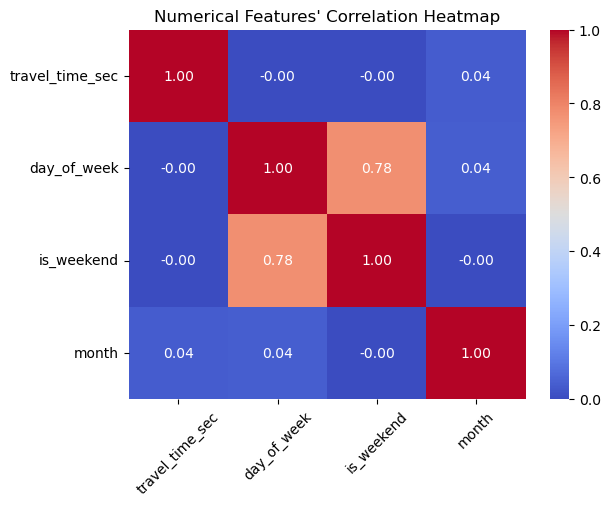

In [4]:
temp_df = df.drop(columns=['direction', 'route_id', 'from_stop_name','to_stop_name', 'API_travel_time_sec'])
corr_matrix = temp_df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title(f"Numerical Features' Correlation Heatmap")
plt.xticks(rotation=45)
plt.show()

#### Select features and target

In [5]:
features = ['day_of_week', 'is_weekend', 'month', 'direction', 'route_id', 'from_stop_name', 'to_stop_name']
target = 'travel_time_sec'

#### Convert categorical features to numeric using one-hot encoding (https://www.geeksforgeeks.org/ml-one-hot-encoding/)

In [7]:
# category_features = ['direction', 'route_id', 'from_stop_name', 'to_stop_name']
# encoder = OneHotEncoder()
# encoded_categories = encoder.fit_transform(df[category_features]).toarray()
# encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(category_features))

label_encoder = LabelEncoder()
df['direction'] = label_encoder.fit_transform(df['direction'])
df['route_id'] = label_encoder.fit_transform(df['route_id'])
df['from_stop_name'] = label_encoder.fit_transform(df['from_stop_name'])
df['to_stop_name'] = label_encoder.fit_transform(df['to_stop_name'])

# df = pd.concat([df, encoded_df], axis=1).drop(columns=category_features)
df = df.iloc[:800000]
df.head()

,route_id,direction,from_stop_name,to_stop_name,travel_time_sec,API_travel_time_sec,day_of_week,is_weekend,month
0,2,1,58,40,1553.0,116.0,0,0,1
1,3,1,34,2,366.0,113.0,0,0,1
2,0,1,2,32,1033.0,95.0,0,0,1
3,3,1,5,35,2963.0,46.0,0,0,1
4,3,0,45,51,685.0,72.0,0,0,1


#### Split data

In [37]:
X = df.drop(columns=[target, 'API_travel_time_sec'])
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#### Linear Regression

In [38]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
lr_predictions = lin_reg_model.predict(X_test)

#### Evaluate Linear Regression Model

In [39]:
print("Linear Regression Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lr_predictions))}")
print(f"MAE: {mean_absolute_error(y_test, lr_predictions)}")
print(f"R^2 Score: {r2_score(y_test, lr_predictions)}")

print()
lr_results = pd.DataFrame()
lr_results["Actual"] = y_test
lr_results["Predicted"] = lr_predictions
print(lr_results)

Linear Regression Evaluation:
RMSE: 765.2082341865873
MAE: 622.9318557753636
R^2 Score: 0.018722988266907215

        Actual    Predicted
212541  1499.0  1049.230665
299551  1710.0  1052.747346
476783   991.0  1017.546224
590090   396.0  1038.900005
139023  1003.0   766.630358
...        ...          ...
408482  1028.0   869.511146
685954  2316.0  1035.740038
205889   592.0  1146.926604
649646  1675.0   903.933400
141279  1783.0   834.509042

[200000 rows x 2 columns]


#### Random Forest

In [42]:
rf_model = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

#### Evaluate Random Forest Model

In [43]:
print("Random Forest Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, rf_predictions))}")
print(f"MAE: {mean_absolute_error(y_test, rf_predictions)}")
print(f"R^2 Score: {r2_score(y_test, rf_predictions)}")

print()
rf_results = pd.DataFrame()
rf_results["Actual"] = y_test
rf_results["Predicted"] = rf_predictions
print(rf_results)

Random Forest Evaluation:
RMSE: 538.1429525177973
MAE: 379.77289452854313
R^2 Score: 0.5146805802128729

        Actual    Predicted
212541  1499.0  1092.666036
299551  1710.0  1482.893549
476783   991.0  1263.637949
590090   396.0   786.005924
139023  1003.0  1131.765973
...        ...          ...
408482  1028.0   906.668693
685954  2316.0  2152.792797
205889   592.0   770.747210
649646  1675.0  1677.571132
141279  1783.0  1501.273471

[200000 rows x 2 columns]


#### Feature Importance

In [44]:
importances = rf_model.feature_importances_
feature_names = X_train.columns
sorted_indices = np.argsort(importances)[::-1]

print("Feature Importance: ")
count = 1
for i in sorted_indices:
    print(f"{count}.) {feature_names[i]}: {importances[i]}")
    count += 1

Feature Importance: 
1.) from_stop_name: 0.3850988083235069
2.) to_stop_name: 0.37063463371309185
3.) direction: 0.1370287406788027
4.) route_id: 0.10614200511337146
5.) month: 0.0008240596684587911
6.) day_of_week: 0.00023929533652570527
7.) is_weekend: 3.2457166242608415e-05


#### Visualize Actual vs Predicted Travel Times

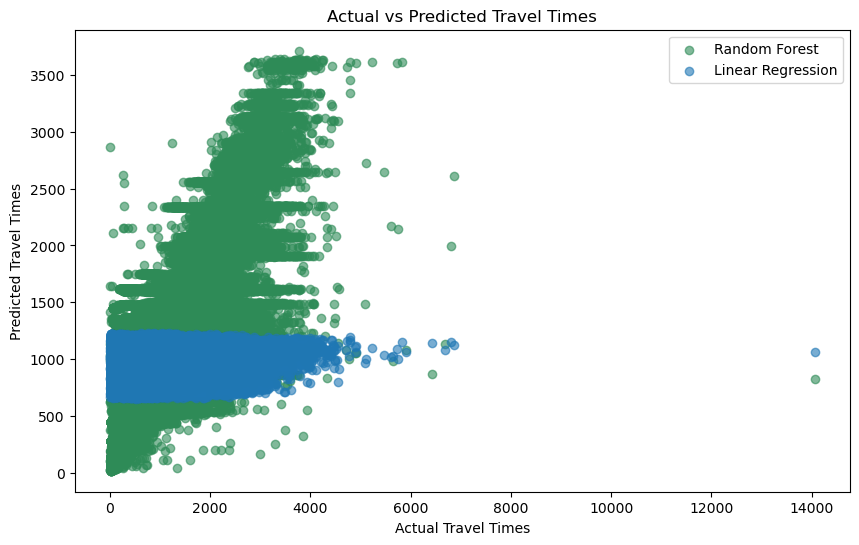

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.6, label='Random Forest', color='seagreen')
plt.scatter(y_test, lr_predictions, alpha=0.6, label='Linear Regression')
plt.xlabel("Actual Travel Times")
plt.ylabel("Predicted Travel Times")
plt.title("Actual vs Predicted Travel Times")
plt.legend()
plt.show()